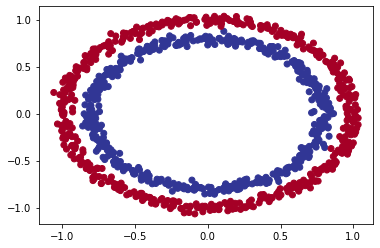

In [1]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y =  make_circles(n_samples,
                    noise = 0.03,
                    random_state = 42)


plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.RdYlBu)

In [2]:
# convert data to tensors and then train and test splits
import torch
from sklearn.model_selection import train_test_split

# turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                   y,
                                                   test_size = 0.2,
                                                   random_state = 42)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

## 6.2  Building a model with non-linearity
* Linear = straight linear
* Non-linear = non-straight lines

In [9]:
nn.ReLU()

ReLU()

In [31]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features = 2, out_features = 10)
        self.layer_2 = nn.Linear(in_features = 10, out_features = 10)
        self.layer_3 = nn.Linear(in_features =10, out_features = 1)
    def forward(self, x):
        return self.layer_3(self.layer_2(self.layer_1(x))) #This way of writing operations leverages speed ups where possible behind the scenes
#         z = self.layer_1(x)
#         z = self.layer_2(z)
#         z = self.layer_3(z)
#         return 4            

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [20]:
# Build a model with non-linear activation functions
from torch import nn
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features = 10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        #Where should we put our non-linear acitvation functions?
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
model_3, model_3.state_dict()

(CircleModelV2(
   (layer_1): Linear(in_features=2, out_features=10, bias=True)
   (layer_2): Linear(in_features=10, out_features=10, bias=True)
   (layer_3): Linear(in_features=10, out_features=1, bias=True)
   (relu): ReLU()
 ),
 OrderedDict([('layer_1.weight',
               tensor([[ 0.5406,  0.5869],
                       [-0.1657,  0.6496],
                       [-0.1549,  0.1427],
                       [-0.3443,  0.4153],
                       [ 0.6233, -0.5188],
                       [ 0.6146,  0.1323],
                       [ 0.5224,  0.0958],
                       [ 0.3410, -0.0998],
                       [ 0.5451,  0.1045],
                       [-0.3301,  0.1802]], device='cuda:0')),
              ('layer_1.bias',
               tensor([-0.3258, -0.0829, -0.2872,  0.4691, -0.5582, -0.3260, -0.1997, -0.4252,
                        0.0667, -0.6984], device='cuda:0')),
              ('layer_2.weight',
               tensor([[ 0.2856, -0.2686,  0.2441,  0.0526, -0.102

In [16]:
# Calculate accuracy - true positive / (true positive + true negative) * 100
# out of a100 examples, what percentage does our model get right

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # Counts how many are correct
    
    acc = (correct/len(y_pred)) * 100
    return acc
# Setting up device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

In [12]:
# Calculate accuracy - true positibe / (True positive + true negative) * 100
# Out of 100 examples, what percentage does our model get right

def accuracy_fn(y_true, y_pred):
    corect = torch.eq(y_true, y_pred).sum().item() #Counts how many are correct
    
    acc = (correct/len(y_pred))

# Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(),
                           lr=0.1)

### 6.3 Training a model with non-linearity

In [33]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Loop through data
epochs = 1000

for epoch in range(epochs):
    ### Training
    model_3.train()
    
    # 1. Forward pass
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> predictions labels
    
    # 2. Calculate the loss
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss (takes in logits as first input)
    acc = accuracy_fn(y_true = y_train,
                     y_pred = y_pred)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()
    
    # 4. Loss backward
    loss.backward()
    
    # 5. Step the optimizer
    optimizer.step()
    
    ### Testing
    model_3.eval()
    with torch.inference_mode():
        test_logits = model_3(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        
        
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true = y_test,
                              y_pred  = test_pred)
        
    # Print out what's happening
    
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.4f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")
    
    

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat1 in method wrapper_addmm)

# 6.4 Evaluating a model trained with non-linear activation functions

In [27]:
# Make predictions
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y[:10] # want preds in same format as truth labels

(tensor([1., 0., 1., 0., 0., 1., 0., 0., 1., 0.], device='cuda:0'),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

In [29]:
import requests
from pathlib import Path

# Download helper fnctions form Learn PyTorch rep (if it's not downloaded)

if Path("helper_functions.py").is_file():
    print("helper_function.py already exists, skipping download")
else:
    print("Download helped_helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

            
from helper_functions import plot_predictions, plot_decision_boundary

helper_function.py already exists, skipping download


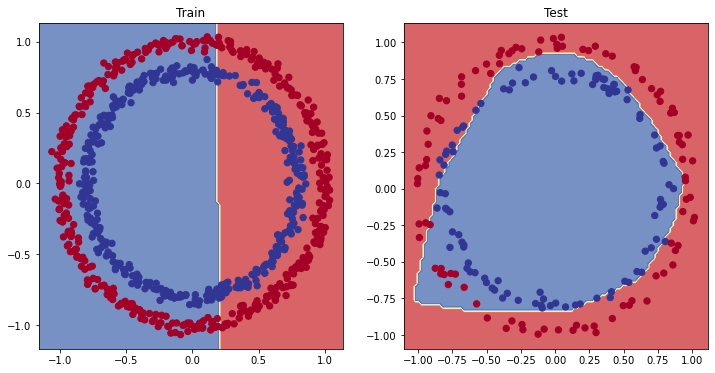

In [32]:

# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test) # model_3 = has non-linearity